In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import scipy.stats as stats
import powerlaw
from levy import fit_levy
import levy

%matplotlib inline
#%matplotlib tk

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
my_data = pd.read_csv('/home/lin/教材/Financial_data/data/finance_M4/my_fx_data', header = None, usecols = [1], names = ['price'])
logR = np.log(my_data).diff()
logR.drop(logR.index[0], inplace = True)

In [3]:
ripple = pd.read_csv('/home/lin/教材/Financial_data/data/Ripple.csv')
ripple['Date']=pd.to_datetime(ripple['Date'])
ripple.set_index('Date', inplace = True)
close = np.flip(ripple['Close'], 0)
logRR = np.log(close).diff()
logRR.drop(logRR.index[0], inplace = True)

In [4]:
def stationarity_tests(data, print_info=True):
    adf_p = adfuller(data)[1]
    KPSS_p = kpss(data)[1]
    
    if print_info:
        print('adfuller test')
        print(adfuller(data))
        print('KPSS test')
        print(kpss(data))
        
    return adf_p, KPSS_p


In [5]:
def get_local_vol(data, days):
    vols = np.zeros(len(data) - days + 1)
    for i in range(len(data) - days + 1):
        vols[i] = np.std(data[i:i+5])
    return vols

In [6]:
#%matplotlib tk
def plot_autocorrelations(data, title):
    autocorr_logR = [data.autocorr(lag=_) for _ in range(1,252)]
    autocorr_abs_logR = [abs(data).autocorr(lag=_) for _ in range(1,252)]
    autocorr_sqLogR = [(data ** 2).autocorr(lag=_) for _ in range(1,252)]
    localVols = pd.Series(get_local_vol(data, 5))
    autocorr_localVols = [localVols.autocorr(lag=_) for _ in range(1,252)]

    plt.figure()
    plt.plot(range(1, 252),autocorr_logR, range(1, 252), autocorr_abs_logR, range(1, 252), autocorr_sqLogR, range(1, 252), autocorr_localVols)
    plt.title(f'Estimated autocorrelation vs lag for {title}', fontsize=20)
    plt.legend(['lot return', '|log return|', 'log return ^2', 'last 5 days vol'], loc = 1)
    plt.xlabel('lag', fontsize=18)
    plt.ylabel('autocorrelation', fontsize=18)
    plt.grid(True)

In [7]:
def fit_a_dist(data, distType, locAndScale=True):
    
    if locAndScale:
        loc = np.mean(data)
        scale = np.std(data)
        para = distType.fit(data, loc = loc, scale = scale)
    else:
        para = distType.fit(data)
        
    return para



In [8]:
def sep_and_mirror(data):
    posiR = data[data > 0].dropna()
    negaR = data[data < 0].dropna()
    sortedPosiR = posiR.sort_values()
    sortedNegaR = (-negaR).sort_values()

    mirrorNegative = sortedNegaR.append(-sortedNegaR)
    mirrorPosi = sortedPosiR.append(-sortedPosiR)
    return sortedPosiR, sortedNegaR, mirrorNegative, mirrorPosi


In [9]:
def get_alpha_and_start(data):
    fit = powerlaw.Fit(data)
    alpha_expo = fit.power_law.alpha
    start_x = fit.xmin
    fit.power_law.plot_ccdf
    fit.plot_ccdf
    return start_x, alpha_expo


In [10]:
def plot_alpha_fitting(data, dist_type, domain_factorf1, domain_factor2, alpha_posi, alpha_nega, adj_start1=0, adj_start2=0):
    posiTail, negaTail, mirrorNega, mirrorPosi = sep_and_mirror(data)
    posiStart, posiAlpha = get_alpha_and_start(posiTail)
    negaStart, negaAlpha = get_alpha_and_start(negaTail)

    plt.figure()
    domain = np.linspace(max(abs(data))/1000, max(abs(data)), 1000)
    plt.loglog(posiTail, 1 - (range(1, posiTail.count() + 1))/(posiTail.count() + 1), '+b', alpha = 0.5)
    plt.loglog(negaTail, 1 - (range(1, negaTail.count() + 1))/(negaTail.count() + 1), 'xr', alpha = 0.5)
    if dist_type == stats.genpareto:
        nega_para = fit_a_dist(negaTail, dist_type, False)
        posi_para = fit_a_dist(posiTail, dist_type, False)
        plt.loglog(domain, 1 - dist_type.cdf(domain, c=posi_para[0] , loc = posi_para[1], scale = posi_para[2]), '--b')
        plt.loglog(domain, 1 - dist_type.cdf(domain, c=nega_para[0] , loc = nega_para[1], scale = nega_para[2]), '--r')
    else:
        nega_para = fit_a_dist(mirrorNega, dist_type, False)
        posi_para = fit_a_dist(mirrorPosi, dist_type, False)
        plt.loglog(domain, 1 - (dist_type.cdf(domain, df =posi_para[0] , loc = posi_para[1], scale = posi_para[2]) - 0.5) * 2, '--b')
        plt.loglog(domain, 1 - (dist_type.cdf(domain, df =nega_para[0] , loc = nega_para[1], scale = nega_para[2]) - 0.5) * 2, '--r')


    plt.loglog(domain, (domain*domain_factorf1) ** (-alpha_posi), '-.b')
    plt.loglog(domain, (domain*domain_factor2) ** (-alpha_nega), '-.r')
    plt.loglog((posiStart+adj_start1)*np.ones(50), np.linspace(1e-4, 1.05), '--b')
    plt.loglog((negaStart+adj_start2)*np.ones(50), np.linspace(1e-4, 1.05), '--r')
    
    if dist_type == stats.genpareto:
        plt.title('compare gen_pareto fited with halves and power law', fontsize=20)
        plt.legend(['positive data', 'negative data', 'gen_pareto positive', 'gen_pareto negative', 'power law positive', 'power law negative'])
        plt.ylim([1e-4, 1.1])
        plt.xlim([10**(-1.2), 1.2])
    else:
        plt.title('compare t fited with mirrored halves and power law', fontsize=20)
        plt.legend(['positive data', 'negative data', 't positive', 't negative', 'power law positive', 'power law negative'])
        plt.ylim([1e-4, 1.05])
        plt.xlim([1e-2, 0.2])

    plt.xlabel('log return', fontsize=18)
    plt.ylabel('rank/cdf', fontsize=18)

In [11]:
def resample(data, days=5):
    data = np.asarray(data)
    resampled = np.zeros(int(len(data)/days))
    j = days-1
    for i in range(len(resampled)):
        resampled[i] = sum(data[j-days+1:j])
        j = j + days
    return resampled

In [12]:
def get_histo_data(data, bins):
    hist, bins = np.histogram(data, bins=bins)
    binCenters = (bins[1:] + bins[:-1]) / 2
    hist = hist/max(hist)
    
    return hist, binCenters

In [13]:
def uni_scale_with_alpha(bins, hist, days, alpha):
    binS = bins/days**(1/alpha)
    histS = hist*days**(1/alpha)/max(hist*days**(1/alpha))
    return binS, histS


In [14]:
def get_and_scale_moments(data, scaleTau=1, alpha=1, scale=True):
    first = np.mean(data)
    firstS = first * scaleTau ** (1 / alpha)
    second = np.mean(data ** 2)
    secondS = second * scaleTau ** (2 / alpha)
    third = np.mean(data ** 3)
    thirdS = third * scaleTau ** (3 / alpha)
    absolu = np.mean(abs(data))
    absoluS = (absolu**2 * scaleTau ** (2 / alpha)) ** 0.5
    print(f'{first}|{second}|{third}|{absolu}|')
    if scale:
        print(f'{firstS}|{secondS}|{thirdS}|{absoluS}|')

    

In [15]:
def genHurst(data, q=1, maxT=19):
    data = np.asarray(data)
    lq = len(q)
    H = np.zeros((maxT-4, lq))
    k = 0;
    
    for Tmax in range(5, maxT+1):
        k = k + 1
        x = np.asarray(range(1, Tmax+1)) * 1.0
        mcord = np.zeros((Tmax, lq))
        for tt in range(1, Tmax+1):
            dV = data[range(tt, len(data), tt)] - data[range(0, len(data)-tt, tt)]
            VV = data[range(0, len(data), tt)]
            N = len(dV) + 1
            X = np.asarray(range(1, N+1)) * 1.0
            Y = VV
            mx = sum(X)/N
            my = sum(Y)/N
            SSxx = sum(X ** 2) - N * mx ** 2
            SSxy = sum(X * Y) - N * mx * my
            cc_1 = SSxy/SSxx
            cc_2 = my - cc_1 * mx
            ddVd = dV - cc_1
            VVVd = VV - cc_1 * np.asarray(range(1, N+1)) - cc_2
            for qq in range(0, len(q)):
                mcord[tt-1, qq] = np.mean(abs(ddVd) ** (q[qq]))/np.mean(abs(VVVd) ** (q[qq]))
        mx = np.mean(np.log(x))
        SSxx = sum(np.log(x) ** 2) - Tmax * mx ** 2
        for qq in range(0, len(q)):
            my = np.mean(np.log(mcord[:, qq]))
            SSxy = sum(np.log(x) * np.log(mcord[:, qq])) - Tmax*mx*my
            H[k-1, qq] = SSxy/SSxx
    
    mH = np.mean(H, 0) / q
    sH = np.std(H, 0) / q
    return mcord, mH, sH

In [16]:
def plot_genHurst(data, minTh, maxTh, steps, maxT = 19):
    q = np.linspace(minTh, maxTh, steps)
    mcord, _, _ = genHurst(data, q, maxT)
    plt.figure()
    plt.loglog(range(1, maxT+1), mcord, '2-', alpha = 0.5)
    qq = range(int(minTh+1), maxTh+1)
    mcord, mH, sH = genHurst(data, qq, maxT)
    plt.loglog(range(1, maxT+1), mcord, 'x-')
    max_q = int(maxTh)
    le = ''
    for i in range(1, max_q):
        ap = f'q = {i}'
        le = le + '\'' + ap + '\', '
    ap = f'q = {max_q}'
    le = le + '\'' + ap + '\''
    print(le)
    #le = list(le)
    #plt.legend([le])
    plt.xlabel(r'$\tau$', fontsize=18)
    plt.ylabel(r'$K_{q(\tau)}$', fontsize=18)

In [17]:
def compare_plot_tauQ_vs_q(original, shuffled, min_q, max_q, steps, maxT=19):
    q = np.linspace(min_q, max_q, steps)
    a, b, c = genHurst(np.cumsum(original), q)
    tau_q = b * q
    band_up = (b + c) * q
    band_down = (b - c) * q
    plt.figure()
    plt.plot(q, tau_q, 'b', q, band_up, '--y', q, band_down, '--y')
    a, b, c = genHurst(np.cumsum(shuffled), q)
    tau_q = b * q
    band_up = (b + c) * q
    band_down = (b - c) * q
    plt.plot(q, tau_q, 'r', q, band_up, '--g', q, band_down, '--g')
    plt.plot(q, np.ones(len(q)), '-.k')
    
    plt.legend(['original', 'ori_up', 'ori_down', 'shuffled', 'shu_up', 'shu_down'])
    plt.xlabel('q', fontsize=18)
    plt.ylabel('qH(q)', fontsize=18)
    plt.title(r'compare $\tau(q)$ between original and shuffled data', fontsize=20)


In [18]:
def compare_plot_tauQ_vs_q(original, shuffled, min_q, max_q, steps, maxT=19):
    q = np.linspace(min_q, max_q, steps)
    a, b, c = genHurst(np.cumsum(original), q)
    tau_q = b * q
    band_up = (b + c) * q
    band_down = (b - c) * q
    plt.figure()
    plt.plot(q, tau_q, 'b', q, band_up, '--y', q, band_down, '--y')
    a, b, c = genHurst(np.cumsum(shuffled), q)
    tau_q = b * q
    band_up = (b + c) * q
    band_down = (b - c) * q
    plt.plot(q, tau_q, 'r', q, band_up, '--g', q, band_down, '--g')
    
    plt.legend(['original', 'ori_up', 'ori_down', 'shuffled', 'shu_up', 'shu_down'])
    plt.xlabel('q', fontsize=18)
    plt.ylabel('qH(q)', fontsize=18)
    plt.title(r'compare $\tau(q)$ between original and shuffled data', fontsize=20)


In [19]:
def delta_H(original, shuffled, min_q, max_q):
    _, b, _ = genHurst(np.cumsum(original), [min_q, max_q])
    delta = b[0] - b[1]
    print(f'original: H({min_q}) - H({max_q}) = {delta}')
    _, b, _ = genHurst(np.cumsum(shuffled), [min_q, max_q])
    delta = b[0] - b[1]
    print(f'shuffled: H({min_q}) - H({max_q}) = {delta}')

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


adfuller test
(-23.262701610140457, 0.0, 6, 4189, {'1%': -3.4319120223653132, '5%': -2.8622302155703507, '10%': -2.5671374076308826}, -24993.19087817247)
KPSS test
(0.04591689237306045, 0.1, 31, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(0.0, 0.1)
adfuller test
(-10.924169213029211, 1.0201212291578786e-19, 11, 1606, {'1%': -3.4344283205802606, '5%': -2.8633413399051144, '10%': -2.5677289969277726}, -3606.664273929593)
KPSS test
(0.42111321712474087, 0.06805464779105998, 25, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(1.0201212291578786e-19, 0.06805464779105998)


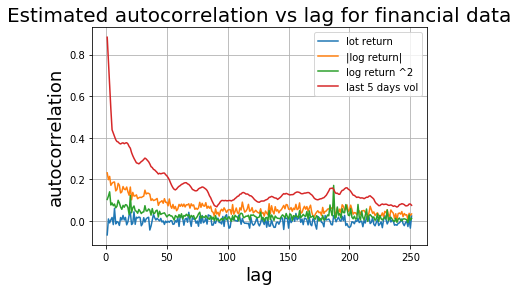

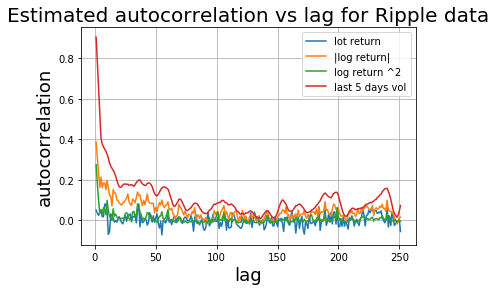

In [20]:
print(stationarity_tests(logR['price']))
print(stationarity_tests(logRR))
plot_autocorrelations(logR['price'], title='financial data')
plot_autocorrelations(logRR, title='Ripple data')

In [21]:
#vol has especially long memory even after a year. The way construct vol here is last 5 days std. But even
#after a year the aucocorrelation is still significant

Calculating best minimal value for power law fit
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit


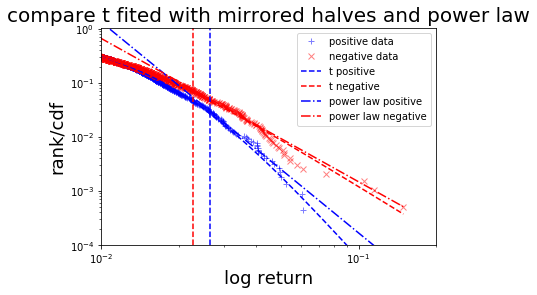

In [22]:
plot_alpha_fitting(logR['price'], stats.t, 93, 117, 3.9, 2.65, adj_start1=0.013, adj_start2=0.008)

In [23]:
#power law how to choose start point  (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3906378/)
#The methods find this start point by creating a power law fit starting from each unique value 
#in the dataset, then selecting the one that results in the minimal Kolmogorov-Smirnov distance
#between the data and the a fit. 

#When fitting alpha, it does a linear regression. The alpha it return is actually alpha+1 by our
#definition so if use, need to subtract 1

#I selected some alpha and start points myself and plotted them together with t distribution fitted with
#mirrored data. Alpha is greater than 2 which means the attractor is a nomal distribution

#Looking at these two fitting, I cannot say t distribution is constently better, but at least for the
#positive tail
#it look more like a t distribution rather than a power law decay. However, the tail we can see is just a
#sample and the real distribution is unknow. To be conservative when fitting alpha, I rather miss some
#point in the middle than miss the points at the very end of the tail


Calculating best minimal value for power law fit
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2062: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


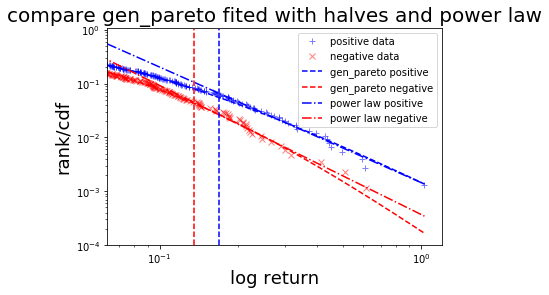

In [24]:
plot_alpha_fitting(logRR, stats.genpareto, 21, 27, 2.15, 2.4, adj_start2=0.05)

In [25]:
#same for ripple, cannot say power law fit better than the gen_pareto and alpha is higher than 2. Both 
#alpha are lower than those for financial data indicating fatter tails but still higher than 2 
#Ripple's positive tail is fatter than negative tail, this is opposite to financial data

In [26]:
#These alphas should be the proper ones to use for scale the tails

Calculating best minimal value for power law fit
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


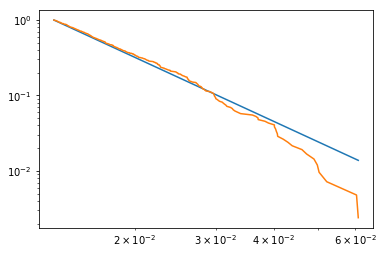

In [27]:
#This it to compare with my alpha and startpoint in the question sheet
#%matplotlib tk   
posiTail, negaTail, mirrorNega, mirrorPosi = sep_and_mirror(logR['price'])

fit = powerlaw.Fit(posiTail)
alpha_expo = fit.power_law.alpha
start_x = fit.xmin
fit.power_law.plot_ccdf()
fit.plot_ccdf()


In [28]:
weeklyF = resample(logR['price'], 5)
print(len(weeklyF))
monthlyF = resample(logR['price'], 21)
print(len(monthlyF))
weeklyR = resample(logRR, 7)
print(len(weeklyR))
threeDR = resample(logRR, 3)
len(threeDR)

839
199
231


539

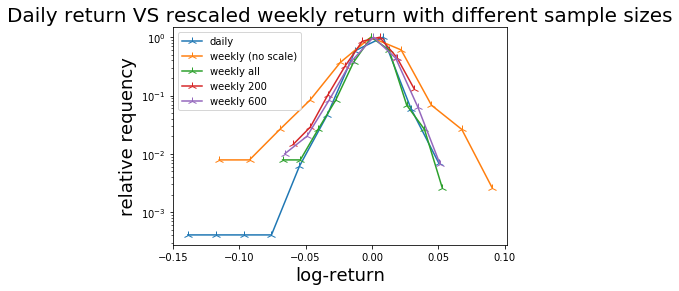

In [29]:
hist, bins = get_histo_data(logR['price'], 10)
histW1, binW1 = get_histo_data(weeklyF[:200], 8)
histW3, binW3 = get_histo_data(weeklyF[:600], 8)
histW, binW = get_histo_data(weeklyF, 10)

binWS, histWS = uni_scale_with_alpha(binW, histW, 5, 3)
binW1S, histW1S = uni_scale_with_alpha(binW1, histW1, 5, 3)
binW3S, histW3S = uni_scale_with_alpha(binW3, histW3, 5, 3)

plt.figure()
plt.semilogy(bins, hist, '-2', binW, histW, '-2', binWS, histWS, '-2', binW1S, histW1S, '-2', binW3S, histW3S, '-2', markersize=9)
plt.title('Daily return VS rescaled weekly return with different sample sizes', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly (no scale)', 'weekly all', 'weekly 200', 'weekly 600'])


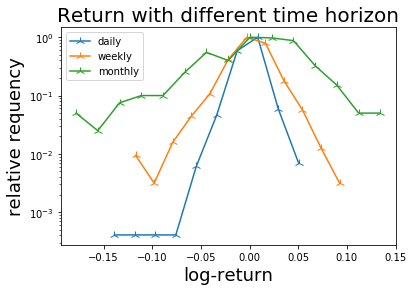

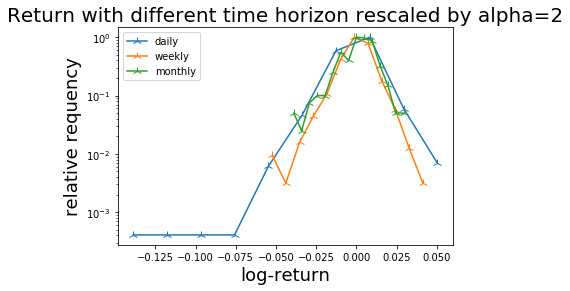

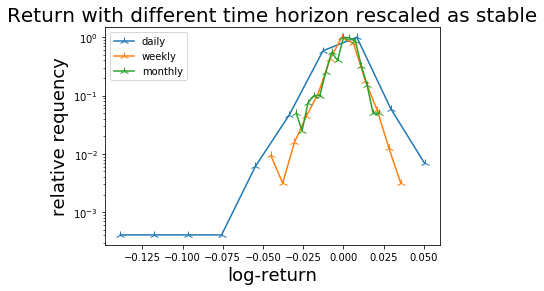

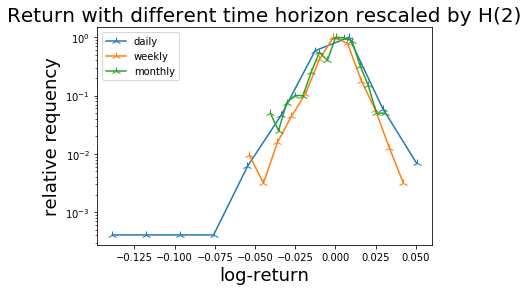

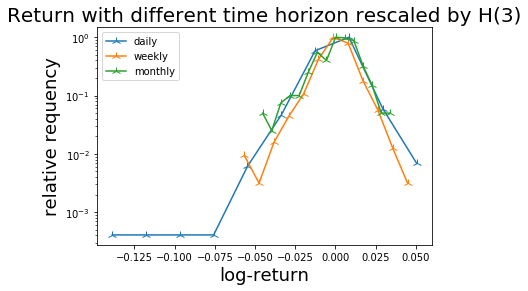

In [30]:
hist, bins = get_histo_data(logR['price'], 10)
histW, binW = get_histo_data(weeklyF, 12)
histM, binM = get_histo_data(monthlyF, 15)

binWS, histWS = uni_scale_with_alpha(binW, histW, 5, 2)
binMS, histMS = uni_scale_with_alpha(binM, histM, 21, 2)


alpha, _, _, _, _ = fit_levy(logR['price'])
binWSA, histWSA = uni_scale_with_alpha(binW, histW, 5, alpha)
binMSA, histMSA = uni_scale_with_alpha(binM, histM, 21, alpha)

plt.figure()
plt.semilogy(bins, hist, '-2', binW, histW, '-2', binM, histM, '-2', markersize=9)
plt.title('Return with different time horizon', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly', 'monthly'])

plt.figure()
plt.semilogy(bins, hist, '-2', binWS, histWS, '-2', binMS, histMS, '-2', markersize=9)
plt.title('Return with different time horizon rescaled by alpha=2', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly', 'monthly'])

plt.figure()
plt.semilogy(bins, hist, '-2', binWSA, histWSA, '-2', binMSA, histMSA, '-2', markersize=9)
plt.title('Return with different time horizon rescaled as stable', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly', 'monthly'])

_, b, _ = genHurst(np.cumsum(logR['price']), [2, 3])

binWS, histWS = uni_scale_with_alpha(binW, histW, 5, 1/b[0])
binMS, histMS = uni_scale_with_alpha(binM, histM, 21, 1/b[0])

plt.figure()
plt.semilogy(bins, hist, '-2', binWS, histWS, '-2', binMS, histMS, '-2', markersize=9)
plt.title('Return with different time horizon rescaled by H(2)', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly', 'monthly'])

binWS, histWS = uni_scale_with_alpha(binW, histW, 5, 1/b[1])
binMS, histMS = uni_scale_with_alpha(binM, histM, 21, 1/b[1])

plt.figure()
plt.semilogy(bins, hist, '-2', binWS, histWS, '-2', binMS, histMS, '-2', markersize=9)
plt.title('Return with different time horizon rescaled by H(3)', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly', 'monthly'])



In [31]:
#When using diff sample sizes, I expect that central limit is getting more and more powerful, and rescaled
#pdf will get closer and closer to daily. But this only really happens when using alpha=3 which is closer
#to the real alpha I found. But when I use alpha=2 to scale diff sample sizes, it is weirld. Which step is
#wrong? Since it has multiple steps and assumptions...
#And when scaking, useing 3 seems better with weekly which has 800+ data points, but worse for monthly,
#which has 200 points

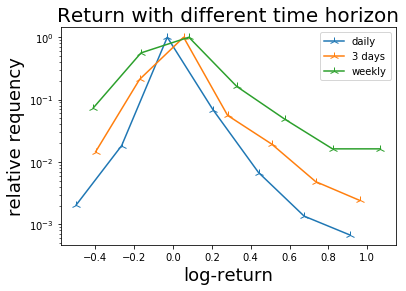

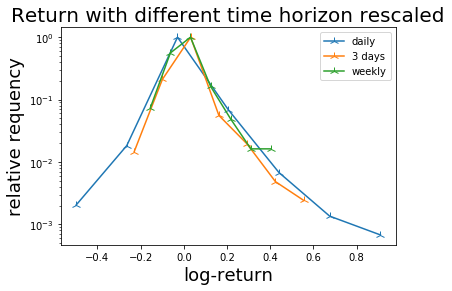

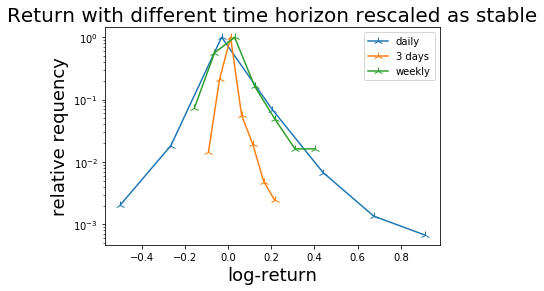

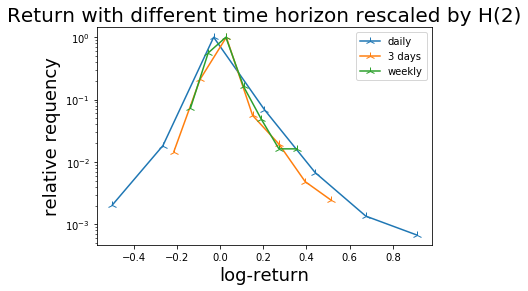

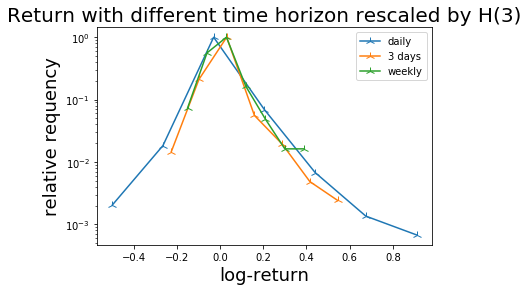

In [32]:
hist, bins = get_histo_data(logRR, 7)
histW, binW = get_histo_data(weeklyR, 7)
histThr, binThr = get_histo_data(threeDR, 7)

binWS, histWS = uni_scale_with_alpha(binW, histW, 7, 2)
binThrS, histThrS = uni_scale_with_alpha(binThr, histThr, 3, 2)

alpha, _, _, _, _ = fit_levy(logRR)
binWSA, histWSA = uni_scale_with_alpha(binW, histW, 7, alpha)
binThrSA, histThrSA = uni_scale_with_alpha(binThrS, histThrS, 3, alpha)


plt.figure()
plt.semilogy(bins, hist, '-2', binThr, histThr, '-2', binW, histW, '-2', markersize=9)
plt.title('Return with different time horizon', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', '3 days', 'weekly'])

plt.figure()
plt.semilogy(bins, hist, '-2', binThrS, histThrS, '-2', binWS, histWS, '-2', markersize=9)
plt.title('Return with different time horizon rescaled', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', '3 days', 'weekly'])

plt.figure()
plt.semilogy(bins, hist, '-2', binThrSA, histThrSA, '-2', binWS, histWS, '-2', markersize=9)
plt.title('Return with different time horizon rescaled as stable', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', '3 days', 'weekly'])

_, b, _ = genHurst(np.cumsum(logRR), [2, 3])

binWS, histWS = uni_scale_with_alpha(binW, histW, 7, 1/b[0])
binThrS, histThrS = uni_scale_with_alpha(binThr, histThr, 3, 1/b[0])

plt.figure()
plt.semilogy(bins, hist, '-2', binThrS, histThrS, '-2', binWS, histWS, '-2', markersize=9)
plt.title('Return with different time horizon rescaled by H(2)', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', '3 days', 'weekly'])

binWS, histWS = uni_scale_with_alpha(binW, histW, 7, 1/b[1])
binThrS, histThrS = uni_scale_with_alpha(binThr, histThr, 3, 1/b[1])

plt.figure()
plt.semilogy(bins, hist, '-2', binThrS, histThrS, '-2', binWS, histWS, '-2', markersize=9)
plt.title('Return with different time horizon rescaled by H(3)', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', '3 days', 'weekly'])

In [33]:
#Ripple rescaled with alpha=2 doesn't look too bad since the real alpha estimated is closer to 2

In [34]:
#In either case, stable alpha scaled badly. Log return has auto correlation only for small lags, main
#validation to the assumption is stable distribution, I guess. Cannot confirm since python don't do it...

In [35]:
get_and_scale_moments(logR['price'], 5, 3)
get_and_scale_moments(weeklyF, scale=False)

0.0002673845240481597|0.00014592963308934022|-1.9091427216812296e-06|0.008468806264022428|
0.00045722110463594987|0.00042670083568412603|-9.545713608406147e-06|0.014481455008543292|
0.0007482750246400601|0.0005504295082676415|-8.075711759690257e-06|0.01688844851843355|


In [36]:
get_and_scale_moments(logR['price'], 5, 2)
get_and_scale_moments(weeklyF, scale=False)

0.0002673845240481597|0.00014592963308934022|-1.9091427216812296e-06|0.008468806264022428|
0.0005978899719031123|0.0007296481654467011|-2.1344864522140956e-05|0.01893682649463018|
0.0007482750246400601|0.0005504295082676415|-8.075711759690257e-06|0.01688844851843355|


In [37]:
#first order moment scale well when using 2, other are closer to real value when using 3, this is not
#uni-scaling

In [38]:
get_and_scale_moments(logRR, 7, 2)
get_and_scale_moments(weeklyR, scale=False)

0.0037305437508001263|0.006407085669118283|0.0011865222735932628|0.04299509733931216|
0.00987009101966325|0.044849599683827984|0.021974700026766998|0.11375433515483484|
0.025320159081880032|0.044174281675448936|0.02177335805025622|0.1262829962553342|


In [39]:
get_and_scale_moments(logRR, 7, 2.2)
get_and_scale_moments(weeklyR, scale=False)

0.0037305437508001263|0.006407085669118283|0.0011865222735932628|0.04299509733931216|
0.009034572563252463|0.0375778108848728|0.016853197625554876|0.10412485490695708|
0.025320159081880032|0.044174281675448936|0.02177335805025622|0.1262829962553342|


In [40]:
#Ripple definitaly likes alpha=2 better, quite close for 2nd and 3rd. But 2.2 is actually closer to the
#alpha of tails. May be 2 is closer to the alpha of the whole distribution

In [41]:
def fit_gama_for_auto(data, gama, cons, adj_start):
    max_lag = 800
    autoLogR = abs(pd.Series([data.autocorr(lag=_) for _ in range(1,max_lag)]))
    domain = np.asarray(range(1, max_lag)) * 1.0

    auto_lag = pd.DataFrame()
    auto_lag['auto'] = autoLogR
    auto_lag['lag'] = domain
    plt.plot(auto_lag['lag'], auto_lag['auto'], '+b', alpha = 0.5)
    plt.plot(auto_lag['lag'], cons*auto_lag['lag']**(-gama), alpha=0.4)
    plt.ylim([0, 1])
    
    auto_lag.sort_values('auto', inplace=True)
    plt.figure()
    plt.loglog(auto_lag['lag'], auto_lag['auto'], '+b', alpha = 0.5)
    plt.loglog(auto_lag['lag'], cons*auto_lag['lag']**(-gama), '2', alpha=0.4)
    
    plt.title('fit gama to auto_correlation decay', fontsize=20)
    plt.legend(['auto-correlation', 'power law decay'])
    plt.ylim([0, 1])
    plt.xlim([600, 800])
    
    plt.xlabel('lag of auto-correlation', fontsize=18)
    plt.ylabel('|auto-correlation|', fontsize=18)
    
    fit = powerlaw.Fit(auto_lag['auto'])
    alpha_expo = fit.power_law.alpha
    print(f'alpha = {alpha_expo}')
    start_x = fit.xmin
    print(f'start = {start_x}')
    fit.power_law.plot_ccdf()
    fit.plot_ccdf()

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
Calculating best minimal value for power law fit
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


alpha = 3.059976543571551
start = 0.10400461504162063


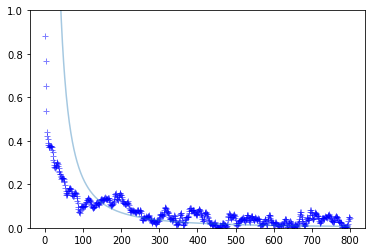

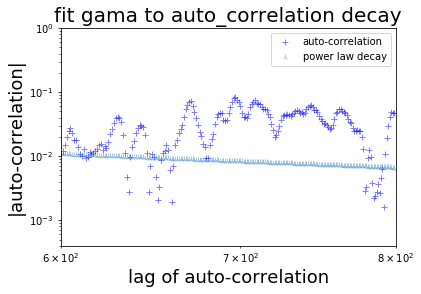

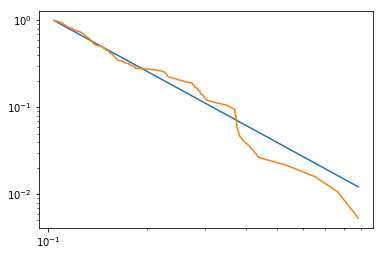

In [42]:
#%matplotlib tk
localVols = pd.Series(get_local_vol(logR['price'], 5))
fit_gama_for_auto(localVols, 1.7, 570, 0)

In [43]:
alpha, beta, loc, scale, likelyhood  = fit_levy(logR['price'])

In [44]:
#This function is from github
#https://github.com/josemiotto/pylevy/blob/master/test.py
"""
The idea of this file is to be able to test the accuracy of the fit.
n_iter sets of size n_data are generated with a Levy distribution of
parameters alpha, beta, mu, sigma.
The 50%, 5% and 95% quantiles of the distributions of the 4 parameters
are returned.
"""
def test_levy(data):
    import levy
    import numpy as np
    from builtins import range
    # from matplotlib import pyplot


    def get_quantiles(l):
        n = float(len(l))
        return l[int(n * 0.5)], l[int(n * 0.05)], l[int(n * 0.95)]

    alpha = 1.0
    beta = 0.0
    mu = 0.0
    sigma = 1.0

    n_iter = 100
    n_data = 1000

    parameters_list = []
    for _ in range(n_iter):
        data = levy.random(alpha, 0.0, 0.0, 1.0, n_data)
        parameters = levy.fit_levy(data)
        parameters_list.append(parameters)
        if _ % 20 == 0:
            print(_)

    alphas = sorted([_[0] for _ in parameters_list])
    betas = sorted([_[1] for _ in parameters_list])
    mus = sorted([_[2] for _ in parameters_list])
    sigmas = sorted([_[3] for _ in parameters_list])

    print(get_quantiles(alphas))
    print(get_quantiles(betas))
    print(get_quantiles(mus))
    print(get_quantiles(sigmas))


In [ ]:
test_levy(logR['price'])

0
20
40
60
80


In [ ]:
shuLogRF = logR['price'].sample(frac = 1).reset_index(drop = True)
plot_autocorrelations(shuLogRF, title='shuffled financial data')
shuLogRR = logRR.sample(frac = 1).reset_index(drop = True)
plot_autocorrelations(shuLogRR, title='shuffled Ripple data')

In [ ]:
plot_genHurst(np.cumsum(logR['price']), 0.5, 4, 20)

In [ ]:
plot_genHurst(np.cumsum(shuLogRF), 0.5, 4, 20)

In [ ]:
#shuffled log return, all lines become more straight, WHY? Straignt line still present, so still scaling

In [ ]:
plot_genHurst(np.cumsum(abs(logR['price'])), 0.5, 4, 20)

In [ ]:
plot_genHurst(np.cumsum(abs(shuLogRF)), 0.5, 4, 20)

In [ ]:
#this one become more wiggley after shuffled The line after shuffled also squiesed together

In [ ]:
plot_genHurst(np.cumsum(logR['price'] ** 2), 0.5, 4, 20)

In [ ]:
plot_genHurst(np.cumsum(shuLogRF ** 2), 0.5, 4, 20)

In [ ]:
#Why after shuffling they all squeised together? log return is a small number and higher order power is
#smaller? But K is nomallized with x^q

In [ ]:
plot_genHurst(my_data['price'], 0.5, 4, 20)

In [ ]:
shuPriceF = my_data['price'].sample(frac = 1).reset_index(drop = True)
plot_genHurst(shuPriceF, 0.5, 4, 20)

In [ ]:
#This one when the auto correlation is destroied, scaling changed a lot. This is not detrended, and far
#far away from stationary

In [ ]:
plot_genHurst(np.cumsum(logRR), 0.5, 4, 20)
plot_genHurst(np.cumsum(shuLogRR), 0.5, 4, 20)
plot_genHurst(np.cumsum(abs(logRR)), 0.5, 4, 20)
plot_genHurst(np.cumsum(abs(shuLogRR)), 0.5, 4, 20)
plot_genHurst(np.cumsum(logRR ** 2), 0.5, 4, 20)
plot_genHurst(np.cumsum(shuLogRR ** 2), 0.5, 4, 20)

In [ ]:
compare_plot_tauQ_vs_q(logR['price'], shuLogRF, 0.5, 7, 30)

In [ ]:
compare_plot_tauQ_vs_q(abs(logR['price']), abs(shuLogRF), 0.5, 7, 30)

In [ ]:
compare_plot_tauQ_vs_q(logR['price']**2, shuLogRF**2, 0.5, 7, 30)

In [ ]:
compare_plot_tauQ_vs_q(logRR, shuLogRR, 0.5, 7, 30)

In [ ]:
compare_plot_tauQ_vs_q(abs(logRR), abs(shuLogRR), 0.5, 7, 30)

In [ ]:
compare_plot_tauQ_vs_q(logRR**2, shuLogRR**2, 0.5, 7, 30)

In [ ]:
delta_H(logR['price'], shuLogRF, 1, 3)

In [ ]:
delta_H(abs(logR['price']), abs(shuLogRF), 1, 3)

In [ ]:
delta_H(logR['price']**2, shuLogRF**2, 1, 3)

In [ ]:
delta_H(logRR, shuLogRR, 1, 3)

In [ ]:
delta_H(abs(logRR), abs(shuLogRR), 1, 3)

In [ ]:
delta_H(logRR**2, shuLogRR**2, 1, 3)

In [ ]:

hist, bins = get_histo_data(logR['price'], 10)
histW, binW = get_histo_data(weeklyF, 12)
histM, binM = get_histo_data(monthlyF, 15)

binWS, histWS = uni_scale_with_alpha(binW, histW, 5, 2)
binMS, histMS = uni_scale_with_alpha(binM, histM, 21, 2)


alpha, _, _, _, _ = fit_levy(logR['price'])
binWSA, histWSA = uni_scale_with_alpha(binW, histW, 5, alpha)
binMSA, histMSA = uni_scale_with_alpha(binM, histM, 21, alpha)

plt.figure()
plt.semilogy(bins, hist, '-2', binW, histW, '-2', binM, histM, '-2', markersize=9)
plt.title('Return with different time horizon', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly', 'monthly'])


plt.figure()
plt.semilogy(bins, hist, '-2', binWSA, histWSA, '-2', binMSA, histMSA, '-2', markersize=9)
plt.title('Return with different time horizon rescaled as stable', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly', 'monthly'])

weeklyFS = resample(shuLogRF, 5)
monthlyFS = resample(shuLogRF, 21)
hist, bins = get_histo_data(shuLogRF, 10)
histW, binW = get_histo_data(weeklyFS, 10)
histM, binM = get_histo_data(monthlyFS, 10)

binWS, histWS = uni_scale_with_alpha(binW, histW, 5, 2)
binMS, histMS = uni_scale_with_alpha(binM, histM, 21, 2)


alpha, _, _, _, _ = fit_levy(shuLogRF)
binWSA, histWSA = uni_scale_with_alpha(binW, histW, 5, alpha)
binMSA, histMSA = uni_scale_with_alpha(binM, histM, 21, alpha)

plt.figure()
plt.semilogy(bins, hist, '-2', binW, histW, '-2', binM, histM, '-2', markersize=9)
plt.title('Return with different time horizon', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly', 'monthly'])


plt.figure()
plt.semilogy(bins, hist, '-2', binWSA, histWSA, '-2', binMSA, histMSA, '-2', markersize=9)
plt.title('Return with different time horizon rescaled as stable', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly', 'monthly'])